In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import List

## Read data

In [9]:
def read_file(file_name: str) -> list:
    with open(file_name) as file:
         return [word.lower() for line in file for word in re.findall(r'\w+', line)]

In [10]:
def parse_data(data: np.ndarray) -> list:
    return [word.lower() for line in data for word in re.findall(r'\w+', line)]

In [112]:
data = pd.read_csv("data/marcel-proust-in-search-of-lost-time/proust_dataset_ENG.csv", sep="@").paragraph
data = parse_data(data)
#data = read_file('data.txt')
print(f'Data size {len(data)}')

Data size 1086651


In [113]:
print(data[:100])

['for', 'a', 'long', 'time', 'i', 'used', 'to', 'go', 'to', 'bed', 'early', 'sometimes', 'when', 'i', 'had', 'put', 'out', 'my', 'candle', 'my', 'eyes', 'would', 'close', 'so', 'quickly', 'that', 'i', 'had', 'not', 'even', 'time', 'to', 'say', 'i', 'm', 'going', 'to', 'sleep', 'and', 'half', 'an', 'hour', 'later', 'the', 'thought', 'that', 'it', 'was', 'time', 'to', 'go', 'to', 'sleep', 'would', 'awaken', 'me', 'i', 'would', 'try', 'to', 'put', 'away', 'the', 'book', 'which', 'i', 'imagined', 'was', 'still', 'in', 'my', 'hands', 'and', 'to', 'blow', 'out', 'the', 'light', 'i', 'had', 'been', 'thinking', 'all', 'the', 'time', 'while', 'i', 'was', 'asleep', 'of', 'what', 'i', 'had', 'just', 'been', 'reading', 'but', 'my', 'thoughts', 'had']


## Plot data

In [114]:
def plot(errors: np.ndarray) -> None:
    fig = plt.figure()
    plt.plot(errors)
    plt.xlabel('iterations')
    plt.ylabel('errors')
    plt.show()

## Matrix factorization

In [115]:
class MatrixFactorization(object):

    def __init__(self, matrix: np.ndarray):
        self.__matrix = matrix
        
    def train(self,
              desired_dimensions: int,
              alpha: float= 1e-2,
              beta: float= 1e-2,
              epsilon: float= 1e-5,
              iterations: int= 1e3,
              auto_adjust_initial_values: bool= True):
        self.U = np.random.rand(self.__matrix.shape[0], desired_dimensions)
        self.V = np.random.rand(self.__matrix.shape[1], desired_dimensions)
        
        if auto_adjust_initial_values:
            mean = np.mean(self.__matrix)
            if mean < 1.0:
                self.U *= mean
                self.V *= mean
        
        return self.__gradient_descent(alpha, beta, epsilon, iterations)
       
    def get_predicted_matrix(self):
        return self.U@self.V.T
    
    def get_vector(self, line: int, column: int) -> np.ndarray:
        return self.U[line] * self.V[column]

    def __gradient_descent(self, alpha, beta, epsilon, iterations) -> np.ndarray:
        current_step = 0
        errors = []
        while True:
            error = self.__matrix - self.get_predicted_matrix()
            old_U = self.U.copy()
            
            
            self.U += alpha * (error @ self.V - beta * self.U)
            self.V += alpha * (error.T @ old_U - beta * self.V)
            errors.append(self.__compute_mean_squared_error())
            current_step += 1
            
            if np.linalg.norm(self.U - old_U) < epsilon or current_step > iterations:
                return {
                    'errors' : errors,
                    'iterations' : current_step
                }
    
    def __compute_mean_squared_error(self) -> np.ndarray:
        return np.mean((self.__matrix - self.get_predicted_matrix()) ** 2)

## Test matrix factorization

In [116]:
matrix = np.arange(25).reshape(5, 5)

matrix_fact = MatrixFactorization(matrix)

factorization_result = matrix_fact.train(desired_dimensions= 10)

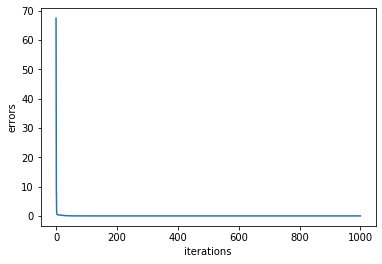

In [117]:
plot(factorization_result['errors'])

In [118]:
print(f'Predicted: \n {np.round(matrix_fact.get_predicted_matrix())}')
print(f'Initial: \n {np.round(matrix)}')

Predicted: 
 [[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19.]
 [20. 21. 22. 23. 24.]]
Initial: 
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


## Word embedding

In [119]:
class WordEmbedding(object):
    
    def __init__(self, data: List[str]):
        self.__data = data
        
    def train(self,
              window_size,
              desired_dimensions: int,
              alpha: float= 1e-2 ,
              beta: float= 1e-2,
              epsilon: float= 1e-5,
              iterations: int= 1e3,
              auto_adjust_initial_values: bool= True):
        
        self.co_occurrence_matrix = self.__build_co_occurrence_matrix(window_size)
        self.probability_matrix = self.__build_probability_matrix()
        self.__matrix_factorization = MatrixFactorization(matrix= self.probability_matrix)
        training_result = self.__matrix_factorization.train(desired_dimensions, alpha, beta, epsilon, iterations)
        self.__embeddings = self.__matrix_factorization.U * self.__matrix_factorization.V
        self.__words_embeddings = dict(zip(self.__words, self.__embeddings))
        return training_result
        
    def get_predicted_matrix(self) -> np.ndarray:
        return self.__matrix_factorization.get_predicted_matrix()
    
    def get_embeddings(self) -> np.ndarray:
        return self.__embeddings
    
    def get_words_embeddings(self) -> np.ndarray:
        return self.__words_embeddings
    
    def get_words(self) -> np.ndarray:
        return self.__words
        
    def __build_co_occurrence_matrix(self, window_size = (10, 10)) -> np.ndarray:
        self.__words = list(set(self.__data))
        number_of_words = len(self.__words)
        self.__vocab = {word:index for index, word in enumerate(self.__words)}
        number_data = np.array([self.__vocab[word] for word in self.__data])
        
        indices = np.arange(len(number_data))[window_size[0]:-window_size[1]].reshape(-1, 1)
        window = np.concatenate((np.arange(start= -window_size[0], stop= 0, step= 1),
                            np.arange(start= 1, stop= window_size[1] + 1, step= 1)))
        co_occurrence_matrix = np.ones(shape= (number_of_words, number_of_words), dtype= np.float)
        co_occurrence_matrix[number_data[indices], number_data[indices + window]] += 1/np.abs(window)
        
        return co_occurrence_matrix
        
    def compute_similarity(self, word: str, words_limit: int) -> np.ndarray:
        res = embeddings.get_embeddings()
        if word in self.__vocab:
            print(self.__vocab)
            print(word)
            print(self.__vocab[word])
            word_index = self.__vocab[word]
            cosine_similarity = (res @ res[word_index]) / (np.linalg.norm(res, axis = 1) * np.linalg.norm(res[word_index]))
            indices = np.argsort(cosine_similarity)[::-1]
            return np.c_[np.array(words), cosine_similarity][indices[:words_limit]]
        return None
        
    def __build_probability_matrix(self) -> np.ndarray:
        return self.co_occurrence_matrix / np.sum(self.co_occurrence_matrix, axis= 1, keepdims= True)

In [121]:
embeddings = WordEmbedding(data)

In [122]:
result = embeddings.train(window_size= (2, 2), desired_dimensions= 10, iterations= 10)

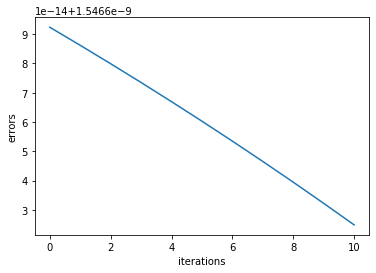

1.5466248523987424e-09


In [123]:
plot(result['errors'])
print(result['errors'][-1])

In [128]:
embeddings.compute_similarity('pneumonia', words_limit= 10)

{'pneumonia': 0, 'proffered': 1, 'marquisate': 2, 'belgian': 3, 'brushing': 4, 'awarded': 5, 'reiterate': 6, 'abhorrence': 7, 'tray': 8, 'squire': 9, 'delays': 10, 'obsolete': 11, 'brandishing': 12, 'sated': 13, 'event': 14, 'deliciously': 15, 'éporcheville': 16, 'efficiency': 17, 'entities': 18, 'obstructing': 19, 'major': 20, 'gondolas': 21, 'brest': 22, 'naturalist': 23, 'shave': 24, 'slender': 25, 'inaccuracy': 26, 'academicians': 27, 'scrupulosity': 28, 'transformed': 29, 'pertained': 30, 'fille': 31, 'mayor': 32, 'flew': 33, 'bosphorus': 34, 'hypothetical': 35, 'jugez': 36, 'crumble': 37, 'impeding': 38, 'excepting': 39, 'downy': 40, 'fiend': 41, 'unpleasing': 42, 'previously': 43, 'viviani': 44, 'parliament': 45, 'nicknamed': 46, 'expectorating': 47, 'negotiable': 48, 'beauty': 49, 'hiss': 50, 'coachman': 51, 'excitement': 52, 'effaced': 53, 'iridescence': 54, 'vermin': 55, 'cream': 56, 'watered': 57, 'la': 58, 'sundered': 59, 'sleeper': 60, 'knees': 61, 'germain': 62, 'historic

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [127]:
embeddings.get_words_embeddings()

{'pneumonia': array([9.27904819e-10, 5.45717011e-10, 8.30997251e-11, 5.03680576e-10,
        1.51363689e-10, 1.84306679e-10, 1.16665144e-10, 3.22786996e-10,
        4.80185177e-10, 1.29384884e-09]),
 'proffered': array([4.84079409e-10, 4.10544316e-10, 1.23202361e-09, 7.63032971e-11,
        4.53503886e-11, 2.86563850e-10, 6.64872145e-10, 1.53661827e-10,
        3.80053407e-11, 3.99695626e-10]),
 'marquisate': array([5.37070706e-11, 3.64265223e-10, 7.39436423e-10, 2.75210779e-10,
        3.46509260e-10, 4.78643133e-11, 3.70898770e-11, 9.89548264e-10,
        1.05992202e-10, 2.65680808e-10]),
 'belgian': array([2.85863209e-10, 5.51937510e-10, 1.08450122e-09, 7.06738114e-10,
        1.03489211e-10, 1.52505084e-10, 1.34818731e-10, 6.44643658e-10,
        2.07945658e-10, 9.41707217e-10]),
 'brushing': array([1.23822128e-09, 9.46246734e-10, 1.06128622e-09, 3.97883517e-10,
        1.13078370e-09, 5.09079922e-11, 3.72819324e-10, 2.06149825e-10,
        7.37097668e-10, 4.08820751e-10]),
 'award

## Visualization

In [102]:
res = embeddings.get_embeddings()
res_norm = (res - np.min(res))/ (np.max(res) - np.min(res))
pca = PCA(n_components=2) #2-dimensional PCA
transformed = pca.fit_transform(res_norm)

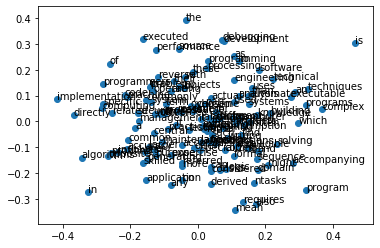

In [103]:
fig, ax = plt.subplots()
x = transformed[:, 0]
y = transformed[:, 1]
words = embeddings.get_words()
ax.scatter(x, y)

for i, word in enumerate(words):
    ax.annotate(word, (x[i], y[i]))
plt.show()

In [104]:
embeddings.compute_similarity('program', words_limit= 10)

array([['program', '1.0'],
       ['and', '0.996042336780292'],
       ['ntasks', '0.9959680852069577'],
       ['also', '0.9957540126043165'],
       ['accompanying', '0.9949407912963711'],
       ['logic', '0.9948137834422479'],
       ['intelligible', '0.9947411132374053'],
       ['mean', '0.9946836252271896'],
       ['solving', '0.9944410151211038'],
       ['programs', '0.9942954177610339']], dtype='<U32')